# Sheet 4

## 2. Trees and random forests

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### b) Optimal splits for 1D binary classification

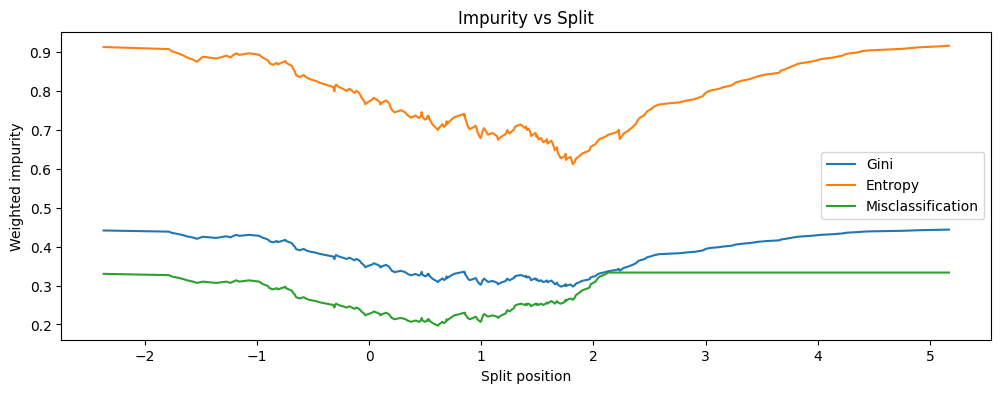

Best Gini split: 1.7079871879922084
Best Entropy split: 1.816156095324053
Best Misclassification split: 0.6148535542802009


In [8]:
# Load data
data = np.load("data/data1d.npy")      # 1D feature array
labels = np.load("data/labels1d.npy")  # 0/1 labels

assert data.shape[0] == labels.shape[0], "Data and labels must have the same length."

# Sort data
sort_idx = np.argsort(data)
data_sorted = data[sort_idx]
labels_sorted = labels[sort_idx]
N = len(data)

# Define functions
def gini(p):
    return 1 - np.sum(p**2)

def entropy(p):
    p_nonzero = p[p > 0]
    return -np.sum(p_nonzero * np.log2(p_nonzero))

def misclassification(p):
    return 1 - np.max(p)

# Compute optimal splits
impurities_gini = []
impurities_entropy = []
impurities_misclass = []
split_positions = []

for i in range(1, N):  # i = size of left node
    left_labels = labels_sorted[:i]
    right_labels = labels_sorted[i:]

    # proportions
    p_left = np.array([np.mean(left_labels == 0), np.mean(left_labels == 1)])
    p_right = np.array([np.mean(right_labels == 0), np.mean(right_labels == 1)])

    # weighted impurity
    w_left = len(left_labels)/N
    w_right = len(right_labels)/N

    impurities_gini.append(w_left*gini(p_left) + w_right*gini(p_right))
    impurities_entropy.append(w_left*entropy(p_left) + w_right*entropy(p_right))
    impurities_misclass.append(w_left*misclassification(p_left) + w_right*misclassification(p_right))

    split_positions.append((data_sorted[i-1] + data_sorted[i])/2)

# Visualise results
plt.figure(figsize=(12,4))
plt.plot(split_positions, impurities_gini, label="Gini")
plt.plot(split_positions, impurities_entropy, label="Entropy")
plt.plot(split_positions, impurities_misclass, label="Misclassification")
plt.xlabel("Split position")
plt.ylabel("Weighted impurity")
plt.title("Impurity vs Split")
plt.legend()
plt.show()

# Find best splits
best_gini_split = split_positions[np.argmin(impurities_gini)]
best_entropy_split = split_positions[np.argmin(impurities_entropy)]
best_misclass_split = split_positions[np.argmin(impurities_misclass)]

print("Best Gini split:", best_gini_split)
print("Best Entropy split:", best_entropy_split)
print("Best Misclassification split:", best_misclass_split)



In [9]:
print(data.shape[0], labels.shape[0])

300 300


### c) Random Forest on jet tagging data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load your jet tagging dataset
X = np.load("data/dijet_features_normalized.npy")  # Features
X = X.T  # Transpose to shape (n_samples, n_features)
y = np.load("data/dijet_labels.npy")    # Labels

# Split: validation and test = 200 each, rest = training
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=200, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=200, random_state=42, stratify=y_temp)

# Hyperparameter grid
n_trees_options = [5, 10, 20, 100]
criteria = ['gini', 'entropy']
max_depth_options = [2, 5, 10, None]  # None = pure

results = []

# Grid search
for n_trees in n_trees_options:
    for criterion in criteria:
        for max_depth in max_depth_options:
            rf = RandomForestClassifier(n_estimators=n_trees,
                                        criterion=criterion,
                                        max_depth=max_depth,
                                        random_state=42)
            rf.fit(X_train, y_train)
            y_val_pred = rf.predict(X_val)
            acc = accuracy_score(y_val, y_val_pred)
            results.append((n_trees, criterion, max_depth, acc))

# Sort by validation accuracy
results.sort(key=lambda x: x[3], reverse=True)
for r in results[:5]:
    print("Trees:", r[0], "Criterion:", r[1], "Max depth:", r[2], "Val Acc:", r[3])

# Train best model on full training set and evaluate on test set
best_n, best_crit, best_depth, _ = results[0]
best_rf = RandomForestClassifier(n_estimators=best_n,
                                 criterion=best_crit,
                                 max_depth=best_depth,
                                 random_state=42)
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Test accuracy with best hyperparameters:", test_acc)



2233 2233 116
Trees: 100 Criterion: entropy Max depth: 10 Val Acc: 0.79
Trees: 100 Criterion: gini Max depth: None Val Acc: 0.78
Trees: 10 Criterion: gini Max depth: 5 Val Acc: 0.765
Trees: 100 Criterion: entropy Max depth: None Val Acc: 0.765
Trees: 20 Criterion: gini Max depth: None Val Acc: 0.76
Test accuracy with best hyperparameters: 0.775
